In [109]:
"""
Standart Python notebook imports

"""

import numpy as np
import pandas as pd

from tqdm.auto import tqdm
from os.path import join
import os
import joblib

from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

from modules.analyzer import extract_features
from modules.cats import cats

In [97]:
"""
Load data

"""

path = os.path.join('data','parquet')

x_train_raw = pd.read_parquet(join(path,'train_values.parquet'))
y_train = pd.read_parquet(join(path,'train_labels.parquet')).to_numpy().reshape(-1)

x_test_raw = pd.read_parquet(join(path,'test_values.parquet'))
y_test = pd.read_parquet(join(path,'test_labels.parquet')).to_numpy().reshape(-1)

In [98]:
"""
Parses a raw string into an array
 
Some strings, such as descriptions, can be quite lengthy. 
To improve performance only the first max_len elements 
of the string are taken.
 
"""

def formatted_to_numpy(value, max_len = 1000):
    value = value[:max_len]
    return np.array(value[2:-2].split("""', '"""))

In [99]:
"""
Runs a feature extractor on each value in a raw DataFrame
The values are taken from the 'values' column. 

Note that the process of running the feature extractor on
all data (400k+ columns) can take a significant amount of time. 

To facilitate testing and experimentation with the model,
a smaller sample size can be set to reduce the features extraction time.

features_keys consists of human-readable 
"""

def features_from_raw(raw, sample_size = 5000):
    values = raw['values'].to_numpy()
    sample = values[:sample_size]
    return np.array([extract_features(formatted_to_numpy(value))[0] for value in tqdm(sample)])

features_keys = extract_features(formatted_to_numpy(x_train_raw['values'][0]))[1]

In [100]:
"""
Tries to load a cached data file

Args: 
    name (str): Name of the file to load.

Returns:
    A tuple (flag, data), where flag is a boolean indicating whether 
    the file was loaded or not, and data is the loaded data or None.
    
"""

def load_cached(name):
    cachedpath = join('cached', name + '.joblib')

    data = None
    loaded = True

    if os.path.isfile(cachedpath):
        user_choice = input(f"File {cachedpath} exists, do you want to load it? (y/n)")
        if user_choice == 'y':
            data = joblib.load(cachedpath)
        else:
            loaded = False
    else:
        loaded = False

    return data, loaded

In [129]:
"""
Saves object into the cached directory.

"""

def save_cached(name, data):
    cachedpath = join('cached', name + '.joblib')
    joblib.dump(data, cachedpath)

In [130]:
"""
Parse data and extract features

Data can be saved or loaded from the "./cached/x_train_features.joblib"
Please note that running the extractor will override existing save.

Set sample_size to smaller numbers (1e3-1e4) for testing

"""

x_train_features, loaded = load_cached('x_train_features')

if not loaded:
    x_train_features = features_from_raw(x_train_raw, sample_size=-1)
    save_cached('x_train_features', x_train_features)
    
x_test_features, loaded = load_cached('x_test_features')

if not loaded:
    x_test_features = features_from_raw(x_test_raw, sample_size=-1)
    save_cached('x_test_features', x_test_features)

File cached/x_train_features.joblib exists, do you want to load it? (y/n) n


  0%|          | 0/412058 [00:00<?, ?it/s]

File cached/x_test_features.joblib exists, do you want to load it? (y/n) n


  0%|          | 0/137352 [00:00<?, ?it/s]

In [134]:
"""
Train model (1) Random Forest

Model can be saved or loaded from the  "./cached/RandomForest.joblib"
Please note that retraining the model will  override existing save.

"""

random_forest, loaded = load_cached('random_forest')
if not loaded:
    random_forest = RandomForestClassifier(n_estimators=10, random_state=0)
    random_forest.fit(x_train_features, y_train[:x_train_features.shape[0]])
    save_cached('random_forest', random_forest)

model = random_forest

File cached/random_forest.joblib exists, do you want to load it? (y/n) n


In [135]:
""" 
Outputs most valuable features paired with importances

sklearn.inspection.permutation_importance is not used due to the high computation time,
although might give more accurate result

"""
#from sklearn.inspection import permutation_importance
#result = permutation_importance(random_forest, x_train_features, y_train[:x_train_features.shape[0]], n_repeats=10,verbose=1)
#importances = result.importances_mean

importances = random_forest.feature_importances_
indices = np.argsort(importances)[::-1]
for p1, p2, in np.vstack((features_keys, importances)).T[indices][:10]:
    print(f"{p1 + (30-len(p1))*' '}: {p2[:6]}")

for p1, p2, in np.vstack((features_keys, importances)).T[indices][::-1][:10]:
    print(f"{p1 + (30-len(p1))*' '}: {p2[:6]}")

length_mean                   : 0.0154
 _occurrence_mean             : 0.0103
length_max                    : 0.0098
uniqueness                    : 0.0094
uppercase_mean                : 0.0092
uppercase_min                 : 0.0082
length_min                    : 0.0081
alphabetic_mean               : 0.0080
 _occurrence_max              : 0.0079
numeric_max                   : 0.0074
_occurence_on_position_9     : 0.0

_occurence_on_position_1     : 0.0
_occurence_on_position_1     : 0.0
_occurence_on_position_1     : 0.0
_occurence_on_position_1     : 0.0
<_occurence_on_position_2     : 0.0
>_occurence_on_position_2     : 0.0
@_occurence_on_position_2     : 0.0
^_occurence_on_position_2     : 0.0
`_occurence_on_position_2     : 0.0


In [107]:
"""
Plots test and train loss and accuracy.

"""

def plot_history(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    epochs = range(1, len(loss) + 1)

    fig, axs = plt.subplots(1, 2, figsize=(15,5))

    axs[0].plot(epochs, loss, 'r', label='Training loss')
    axs[0].plot(epochs, val_loss, 'b', label='Validation loss')
    axs[0].set_title('Training and validation loss')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('Loss')
    axs[0].legend()

    axs[1].plot(epochs, acc, 'r', label='Training accuracy')
    axs[1].plot(epochs, val_acc, 'b', label='Validation accuracy')
    axs[1].set_title('Training and validation accuracy')
    axs[1].set_xlabel('Epochs')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    plt.show()

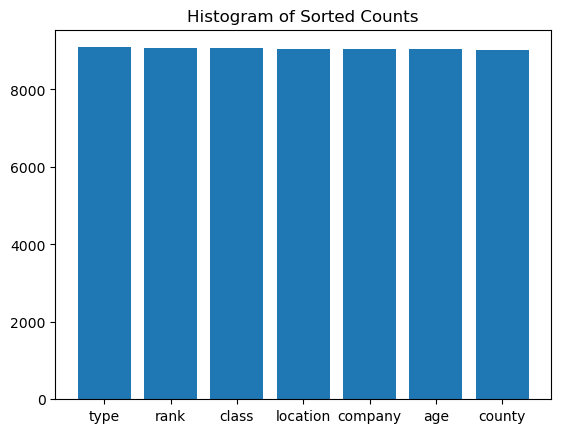

In [131]:
"""
Plots histogram of occurences of most frequent elements in array

"""

def plot_occurences(data, sample_size=7):

    # Get the sorted counts and values
    values, counts = np.unique(data, return_counts=True)
    sorted_counts, sorted_values = zip(*sorted(zip(counts, values), reverse=True))

    # Plot the histogram
    fig, ax = plt.subplots()
    ax.bar(sorted_values[:sample_size], sorted_counts[:sample_size])
    ax.set_xticks(sorted_values[:sample_size])
    ax.set_title('Histogram of Sorted Counts')
    plt.show()

plot_occurences(y_train)

In [136]:
"""
Check the train and test accuracy for the RandomForest.
Accuracy should be close to 1 as we are using random forest here

"""

accuracy = accuracy_score(random_forest.predict(x_train_features), y_train[:x_train_features.shape[0]])
print(f"Train accuracy: {accuracy}")
accuracy = accuracy_score(random_forest.predict(x_test_features), y_test[:x_test_features.shape[0]])
print(f"Test accuracy: {accuracy}")

Train accuracy: 0.9834149561469502
Test accuracy: 0.8277418603296639


Epoch 1/25
805/805 [==============================] - 10s 12ms/step - loss: 1.9357 - accuracy: 0.5551 - val_loss: 1.1843 - val_accuracy: 0.7113
Epoch 2/25
805/805 [==============================] - 10s 12ms/step - loss: 1.1800 - accuracy: 0.7117 - val_loss: 1.0013 - val_accuracy: 0.7510
Epoch 3/25
805/805 [==============================] - 9s 12ms/step - loss: 1.0267 - accuracy: 0.7453 - val_loss: 0.9079 - val_accuracy: 0.7719
Epoch 4/25
805/805 [==============================] - 9s 12ms/step - loss: 0.9405 - accuracy: 0.7641 - val_loss: 0.8442 - val_accuracy: 0.7892
Epoch 5/25
805/805 [==============================] - 10s 12ms/step - loss: 0.8779 - accuracy: 0.7781 - val_loss: 0.8151 - val_accuracy: 0.7951
Epoch 6/25
805/805 [==============================] - 10s 12ms/step - loss: 0.8317 - accuracy: 0.7876 - val_loss: 0.7874 - val_accuracy: 0.8010
Epoch 7/25
805/805 [==============================] - 10s 12ms/step - loss: 0.7910 - accuracy: 0.7971 - val_loss: 0.7559 - val_accuracy: 0

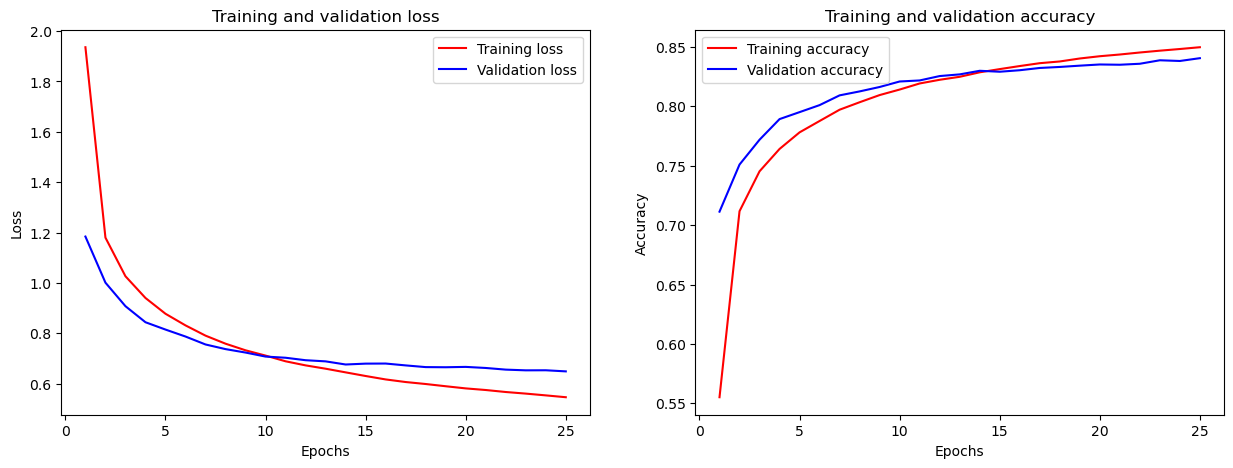

In [138]:
"""
Train model (2) Neural Network

TODO Model can be saved or loaded from the  "./cached/nn2.joblib"
Please note that running the training will override existing save.

"""

# Get numeric encoding for target vectors
y_train_numeric = np.array([cats[y] for y in y_train])
y_test_numeric = np.array([cats[y] for y in y_test])

# Load data
y_train_categorical = keras.utils.to_categorical(y_train_numeric[:x_train_features.shape[0]], 78)
y_test_categorical = keras.utils.to_categorical(y_test_numeric[:x_test_features.shape[0]], 78)

# Build the model
model = keras.Sequential([
    keras.layers.Dense(500, activation='relu', input_shape=(x_train_features.shape[1],)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(500, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(78, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train_features, y_train_categorical, epochs=25, batch_size=512, verbose=1,
                    validation_data=(x_test_features, y_test_categorical))

# Evaluate the model on test data
test_loss, test_acc = model.evaluate(x_test_features, y_test_categorical)
print('Test accuracy:', test_acc)
plot_history(history)


In [139]:
"""
This code performs manual checks on the prediction results using Random Forest.

This block outputs the model's predictions on the first 10 test samples
and writes data in a fancy way.

It can be helpful in identifying poorly predicted types and gaining insights 
into the model's behavior.

"""

model = random_forest

def top_classes(preds):
    top_indices = np.argsort(preds[0])[::-1][:3]
    
    top_types = model.classes_[top_indices]
    top_probs = preds[0][top_indices]
    
    return dict(zip(top_types, top_probs))

for i in range(10):
    preds = model.predict_proba(x_test_features[i].reshape(1, -1))
    top = top_classes(preds)
    value_sample = x_test_raw['values'].to_numpy()[i][1:60]
    
    print("Values    : ", value_sample, ". . .")
    print("Predicted : ", top)
    print("Truth     : ", y_test[i], '\n')


Values    :  'Central Missouri', 'unattached', 'unattached', 'Kansas Sta . . .
Predicted :  {'affiliation': 0.3, 'country': 0.2, 'category': 0.2}
Truth     :  affiliation 

Values    :  95, 100, 95, 89, 84, 91, 88, 94, 75, 78, 90, 84, 90, 76, 93 . . .
Predicted :  {'rank': 0.3, 'plays': 0.3, 'education': 0.2}
Truth     :  weight 

Values    :  'Katie Crews', 'Christian Hiraldo', 'Alex Estrada', 'Fredy  . . .
Predicted :  {'jockey': 0.9, 'owner': 0.1, 'year': 0.0}
Truth     :  jockey 

Values    :  'Christian', 'Non-Christian', 'Unreported', 'Jewish', 'Athe . . .
Predicted :  {'type': 0.2, 'language': 0.1, 'name': 0.1}
Truth     :  religion 

Values    :  'AAF-McQuay Canada Inc.', 'AAF-McQuay Canada Inc.', 'Abilit . . .
Predicted :  {'company': 0.3, 'album': 0.2, 'description': 0.1}
Truth     :  company 

Values    :  '05 - 08', '04 - 08', '06 - 09', '05 - 08', '06 - 08', '06  . . .
Predicted :  {'grades': 1.0, 'depth': 0.0, 'continent': 0.0}
Truth     :  grades 

Values    :  'Cerulean

In [140]:
"""
This is where you can test the classifier on your own custom samples!
Enjoy experimenting with the model :D

Please be aware that the performance  may be poor when
working with a small number of samples, as it relies on
the global statistics collected from a large dataset.

"""

your_samples = np.array([
    ["Alice", "Bob", "Donald", "Duda", "Petro", "Jacek"],
    ["12/21/2004"],
    ["Ukraine", "Poland", "China"],
    ["male", "female", "male", "m", "m", "f"],
    [""]
], dtype=object)

for sample in your_samples:
    preds = model.predict_proba(extract_features(sample)[0].reshape(1,-1))
    top = top_classes(preds)
    print(top)

{'city': 0.3, 'person': 0.2, 'type': 0.2}
{'year': 0.7, 'duration': 0.2, 'day': 0.1}
{'country': 0.6, 'team Name': 0.2, 'type': 0.1}
{'gender': 0.3, 'sex': 0.3, 'symbol': 0.1}
